# Recruit Restaurant Visitor Forecasting

website = https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data

Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business.

One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

Recruit Holdings has unique access to key datasets that could make automated future customer prediction possible. Specifically, Recruit Holdings owns **Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software)**.

In this competition, you're challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

In this competition, you are provided a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites:

    Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
    AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

**You must use the reservations, visits, and other information from these sites**  to forecast future restaurant visitor totals on a given date. The **training data covers the dates from 2016 until April 2017**. The **test set covers the last week of April and May of 2017**. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. **Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."**

**There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.**


File Descriptions

This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

air_reserve.csv

This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

    air_store_id - the restaurant's id in the air system
    visit_datetime - the time of the reservation
    reserve_datetime - the time the reservation was made
    reserve_visitors - the number of visitors for that reservation

hpg_reserve.csv

This file contains reservations made in the hpg system.

    hpg_store_id - the restaurant's id in the hpg system
    visit_datetime - the time of the reservation
    reserve_datetime - the time the reservation was made
    reserve_visitors - the number of visitors for that reservation

air_store_info.csv

This file contains information about select air restaurants. Column names and contents are self-explanatory.

    air_store_id
    air_genre_name
    air_area_name
    latitude
    longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
hpg_store_info.csv

This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

    hpg_store_id
    hpg_genre_name
    hpg_area_name
    latitude
    longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
store_id_relation.csv

This file allows you to join select restaurants that have both the air and hpg system.

    hpg_store_id
    air_store_id

air_visit_data.csv

This file contains historical visit data for the air restaurants.

    air_store_id
    visit_date - the date
    visitors - the number of visitors to the restaurant on the date

sample_submission.csv

This file shows a submission in the correct format, including the days for which you must forecast.

    id - the id is formed by concatenating the air_store_id and visit_date with an underscore
    visitors- the number of visitors forecasted for the store and date combination

date_info.csv

This file gives basic information about the calendar dates in the dataset.

    calendar_date
    day_of_week
    holiday_flg - is the day a holiday in Japan


In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
import folium
from plotnine import *

from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from datetime import timedelta
from folium.plugins import MarkerCluster

In [2]:
user = '/WilliamHoltam'  # Configure this with your username

data_repo = Path(
    r'C:\Users' +
    user +
    '\Datalytyx\Delivery - Documents\Data Science\Data\Recruit_Restaurant_Visitor_Forecasting'
)

data_list = [
    'air_reserve',
    'air_store_info',
    'air_visit_data',
    'date_info',
    'hpg_reserve',
    'hpg_store_info',
    'store_id_relation'
]

air_reserve = pd.read_csv(
    data_repo/'air_reserve.csv',
    parse_dates=['visit_datetime', 'reserve_datetime']
)  # Reservations made in the air system.

air_store_info = pd.read_csv(
    data_repo/'air_store_info.csv'
)  # Information about select air restaurants

air_visit_data = pd.read_csv(
    data_repo/'air_visit_data.csv',
    parse_dates=['visit_date']
)  # Historical visit data for the air restaurants.

date_info = pd.read_csv(
    data_repo/'date_info.csv',
    parse_dates=['calendar_date']
)  # Basic information about the calendar dates in the dataset.

hpg_reserve = pd.read_csv(
    data_repo/'hpg_reserve.csv',
    parse_dates=['visit_datetime', 'reserve_datetime']
)  # Reservations made in the hpg system.

hpg_store_info = pd.read_csv(
    data_repo/'hpg_store_info.csv'
)  # Information about select hpg restaurants

store_id_relation = pd.read_csv(
    data_repo/'store_id_relation.csv'
)  # This file allows you to join select restaurants that have both the air and hpg system.

sample_submission = pd.read_csv(data_repo/'sample_submission.csv')  # Submission example

In [3]:
print("There are NaNs in air_reserve: ", air_reserve.isnull().values.any())
print("There are NaNs in air_store_info: ", air_store_info.isnull().values.any())
print("There are NaNs in air_visit_data: ", air_visit_data.isnull().values.any())
print("There are NaNs in date_info: ", date_info.isnull().values.any())
print("There are NaNs in hpg_reserve: ", hpg_reserve.isnull().values.any())
print("There are NaNs in hpg_store_info: ", hpg_store_info.isnull().values.any())
print("There are NaNs in store_id_relation: ", store_id_relation.isnull().values.any())

There are NaNs in air_reserve:  False
There are NaNs in air_store_info:  False
There are NaNs in air_visit_data:  False
There are NaNs in date_info:  False
There are NaNs in hpg_reserve:  False
There are NaNs in hpg_store_info:  False
There are NaNs in store_id_relation:  False


* There are no missing values in the datasets

In [4]:
class DateFromDateType64Extractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        
        self.dt_columns = X.select_dtypes(include='datetime64').columns.values.tolist()

        return self
    
    def transform(self, X):
    
        for i in self.dt_columns:
            X[i+'_date'] = X[i].dt.date  # use pandas dt method as it is vectorised and therfore produces the result fastest
            X[i+'_time'] = X[i].dt.time
        
        print("The following columns contain datetime64 data: ")
        print(self.dt_columns)
        print("")
        
        return X
    
air_reserve = DateFromDateType64Extractor().fit_transform(air_reserve)
hpg_reserve = DateFromDateType64Extractor().fit_transform(hpg_reserve)
date_info = DateFromDateType64Extractor().fit_transform(date_info)

The following columns contain datetime64 data: 
['visit_datetime', 'reserve_datetime']

The following columns contain datetime64 data: 
['visit_datetime', 'reserve_datetime']

The following columns contain datetime64 data: 
['calendar_date']



In [5]:
air_reserve.info()
air_reserve.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 8 columns):
air_store_id             92378 non-null object
visit_datetime           92378 non-null datetime64[ns]
reserve_datetime         92378 non-null datetime64[ns]
reserve_visitors         92378 non-null int64
visit_datetime_date      92378 non-null object
visit_datetime_time      92378 non-null object
reserve_datetime_date    92378 non-null object
reserve_datetime_time    92378 non-null object
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 5.6+ MB


air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   

   reserve_visitors visit_datetime_date visit_datetime_time  \
0                 1          2016-01-01            19:00:00   
1                 3          2016-01-01            19:00:00   

  reserve_datetime_date reserve_datetime_time  
0            2016-01-01              16:00:00  
1            2016-01-01              19:00:00

In [6]:
air_store_info.info()
air_store_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   

    latitude   longitude  
0  34.695124  135.197852  
1  34.695124  135.197852

In [7]:
air_visit_data.info()
air_visit_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null datetime64[ns]
visitors        252108 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


air_store_id visit_date  visitors
0  air_ba937bf13d40fb24 2016-01-13        25
1  air_ba937bf13d40fb24 2016-01-14        32

In [8]:
date_info.info()
date_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 5 columns):
calendar_date         517 non-null datetime64[ns]
day_of_week           517 non-null object
holiday_flg           517 non-null int64
calendar_date_date    517 non-null object
calendar_date_time    517 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 20.3+ KB


calendar_date day_of_week  holiday_flg calendar_date_date calendar_date_time
0    2016-01-01      Friday            1         2016-01-01           00:00:00
1    2016-01-02    Saturday            1         2016-01-02           00:00:00

In [9]:
hpg_reserve.info()
hpg_reserve.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 8 columns):
hpg_store_id             object
visit_datetime           datetime64[ns]
reserve_datetime         datetime64[ns]
reserve_visitors         int64
visit_datetime_date      object
visit_datetime_time      object
reserve_datetime_date    object
reserve_datetime_time    object
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 122.1+ MB


hpg_store_id      visit_datetime    reserve_datetime  \
0  hpg_c63f6f42e088e50f 2016-01-01 11:00:00 2016-01-01 09:00:00   
1  hpg_dac72789163a3f47 2016-01-01 13:00:00 2016-01-01 06:00:00   

   reserve_visitors visit_datetime_date visit_datetime_time  \
0                 1          2016-01-01            11:00:00   
1                 3          2016-01-01            13:00:00   

  reserve_datetime_date reserve_datetime_time  
0            2016-01-01              09:00:00  
1            2016-01-01              06:00:00

In [10]:
hpg_store_info.info()
hpg_store_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221

In [11]:
store_id_relation.info()
store_id_relation.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
air_store_id    150 non-null object
hpg_store_id    150 non-null object
dtypes: object(2)
memory usage: 2.4+ KB


air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809

## EDA Examine Visitor Numbers Over Time (air_visit_data) as it is the training data

In [12]:
air_visit_data.head(3)

air_store_id visit_date  visitors
0  air_ba937bf13d40fb24 2016-01-13        25
1  air_ba937bf13d40fb24 2016-01-14        32
2  air_ba937bf13d40fb24 2016-01-15        29

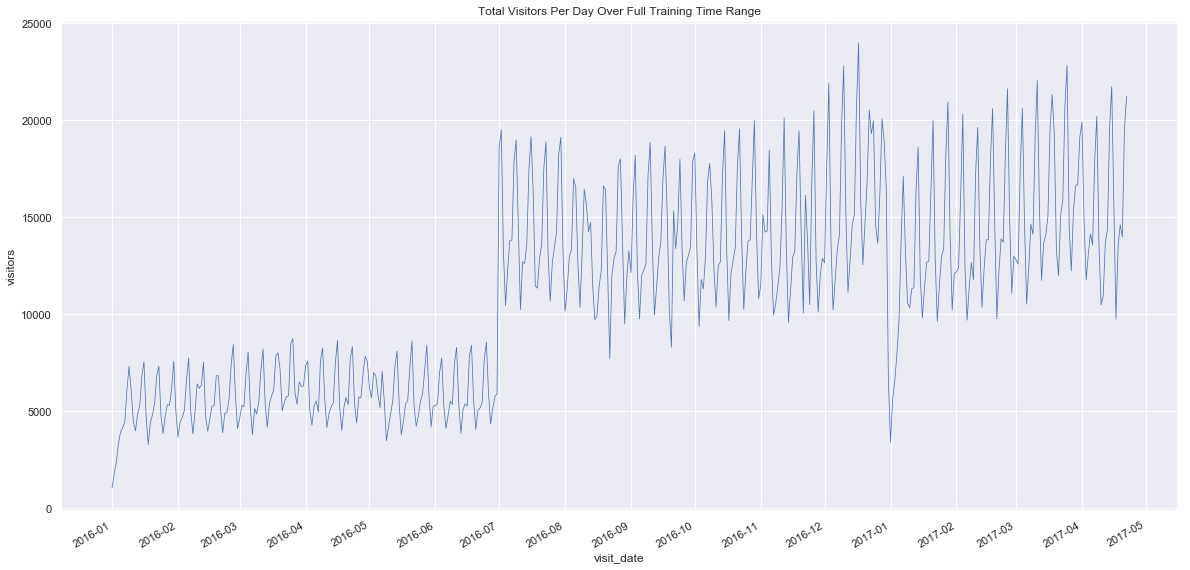

In [13]:
data = air_visit_data.groupby(["visit_date"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(
    x="visit_date",
    y="visitors",
    size=3.0,
    data=data,
    legend=False,
    palette="Set2"
)

fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Total Visitors Per Day Over Full Training Time Range')

plt.show()

* Long-term step structure

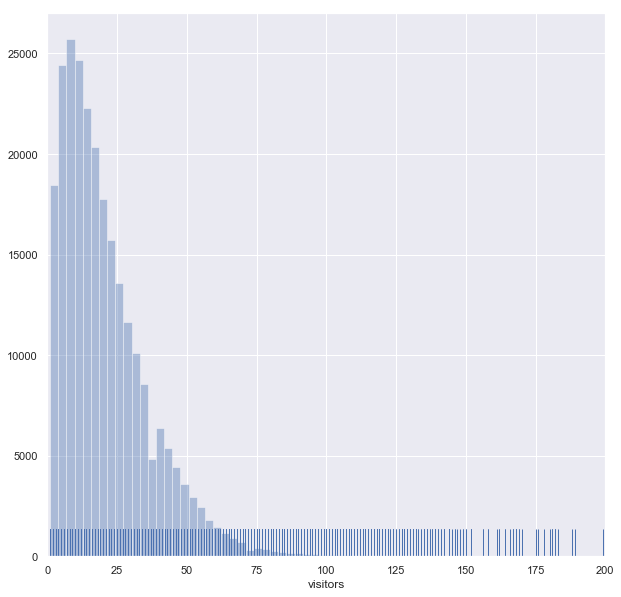

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

data = air_visit_data

sns.distplot(
    a=data["visitors"],
    hist=True,
    kde=False,
    rug=True,
    bins=300
)

plt.xlim(0.00,200)

plt.show()

* The number of guests per visit per restaurant per day peaks at around 20. 
* The distribution extends up to 100 occasionally beyond.

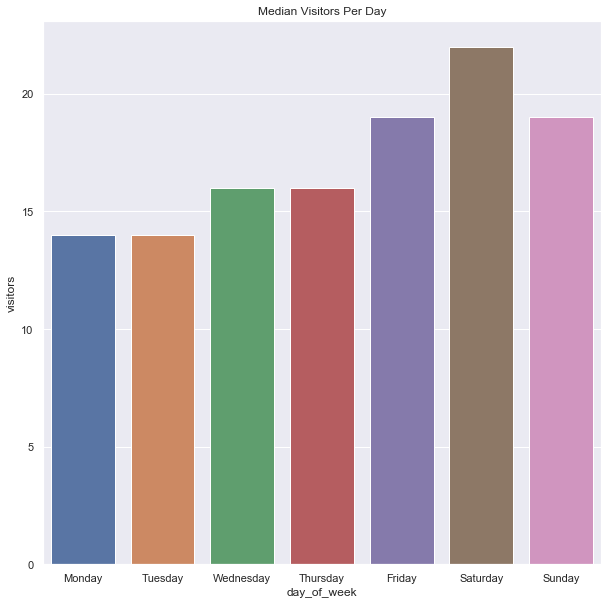

In [15]:
air_visit_data["day_of_week"] = air_visit_data["visit_date"].dt.day_name()
air_visit_data["day_of_week_no"] = air_visit_data['visit_date'].dt.dayofweek

data = air_visit_data.groupby("day_of_week").median().sort_values("day_of_week_no").reset_index()

# data = data.drop(["day_of_week_no"], axis=1)

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(
    x="day_of_week",
    y="visitors",
    data=data,
    estimator=np.median
)

plt.title("Median Visitors Per Day")

plt.show()

* Friday and the weekend appear to be the most popular days; which is to be expected.
* Monday and Tuesday have the lowest numbers of average visitors.

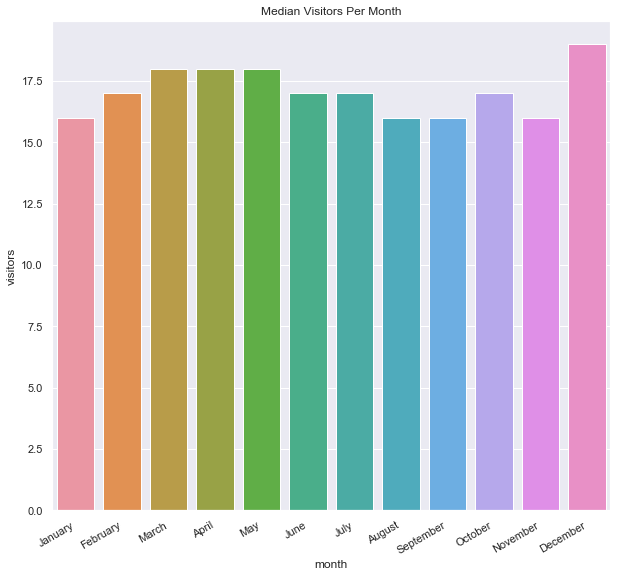

In [16]:
air_visit_data["month"] = air_visit_data["visit_date"].dt.month_name()
air_visit_data["month_no"] = air_visit_data['visit_date'].dt.month

data = air_visit_data.groupby("month").median().sort_values("month_no").reset_index()

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(
    x="month",
    y="visitors",
    data=data,
    estimator=np.median
)

plt.title("Median Visitors Per Month")

fig.autofmt_xdate()

plt.show()

* Seasonality through out the year. Dec is the most popular month for restaurant visits.
* The period of Mar - May is consistently busy.

We will be forecasting the last week of April + May 2017 so look at this time range in the 2016 training data:

In [17]:
data = air_visit_data.loc[np.logical_and(air_visit_data["visit_date"] > "2016-04-15", air_visit_data["visit_date"] < "2016-06-15")]
data = data.groupby(by="visit_date").sum().reset_index()
data.head()

visit_date  visitors  day_of_week_no  month_no
0 2016-04-16      8656            1460      1168
1 2016-04-17      5253            1320       880
2 2016-04-18      4011               0       932
3 2016-04-19      5181             272      1088
4 2016-04-20      5706             562      1124

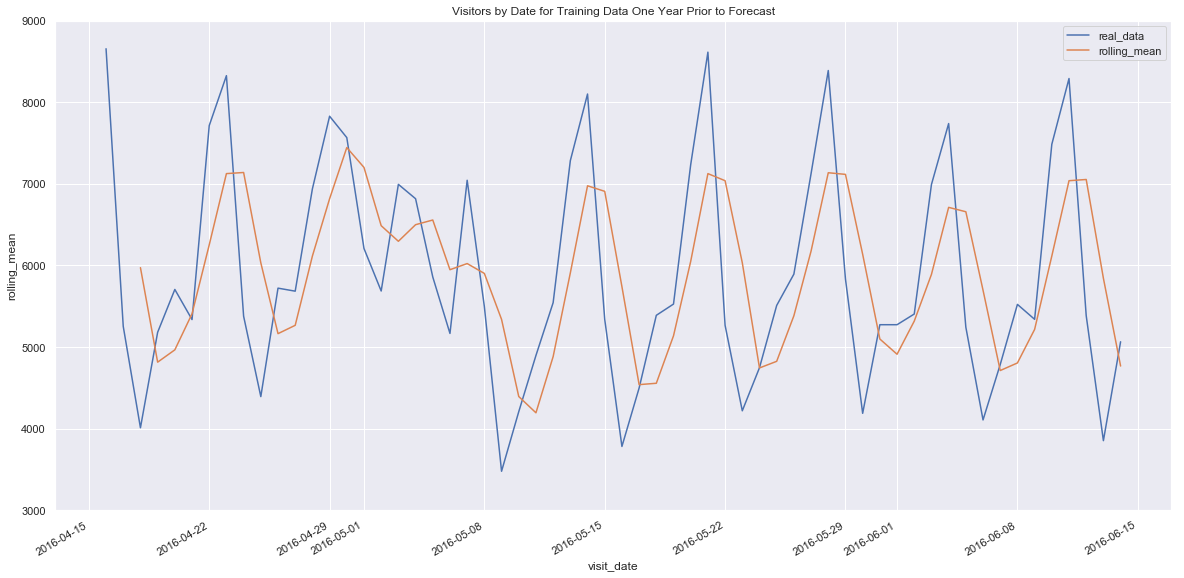

In [18]:
data["rolling_mean"] = data["visitors"].rolling(3).mean()

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(
    x="visit_date",
    y="visitors",
    data=data,
    label="real_data",
    palette="Set2"
)

sns.lineplot(
    x="visit_date",
    y="rolling_mean",
    data=data,
    label="rolling_mean",
    palette="Set2"
)

plt.title("Visitors by Date for Training Data One Year Prior to Forecast")

plt.ylim(3000,9000)

fig.autofmt_xdate()

plt.show()

You can see the weekly seasonality, paticularly in the rolling mean plot. The holiday mentioned in the description "The Golden Week" is clearly visible ~ between 2-16-05-01 and 2016-05-09

## EDA Compare Air Reservation Data (air_reserve) to Visitor Numbers (air_visit_data)

In [19]:
air_reserve.head(3)

air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   

   reserve_visitors visit_datetime_date visit_datetime_time  \
0                 1          2016-01-01            19:00:00   
1                 3          2016-01-01            19:00:00   
2                 6          2016-01-01            19:00:00   

  reserve_datetime_date reserve_datetime_time  
0            2016-01-01              16:00:00  
1            2016-01-01              19:00:00  
2            2016-01-01              19:00:00

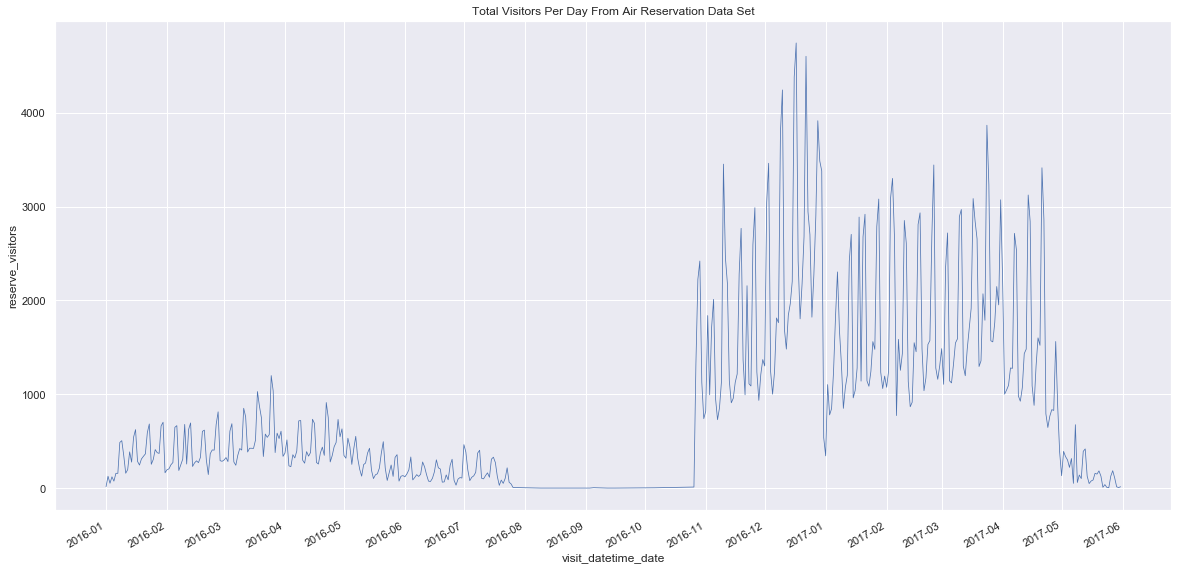

In [20]:
data = air_reserve.groupby(["visit_datetime_date"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(
    x="visit_datetime_date",
    y="reserve_visitors",
    size=3.0,
    data=data,
    legend=False,
    palette="Set2"
)

fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Total Visitors Per Day From Air Reservation Data Set')

plt.show()

* Fewer Reservations made through air system in 2016. None at all between 2016-08 and 2016-11
* The decline we see after the first quarter is most likely related to these reservations being at the end of the training time frame, which means that long-term reservations would not be part of this data set.

[]

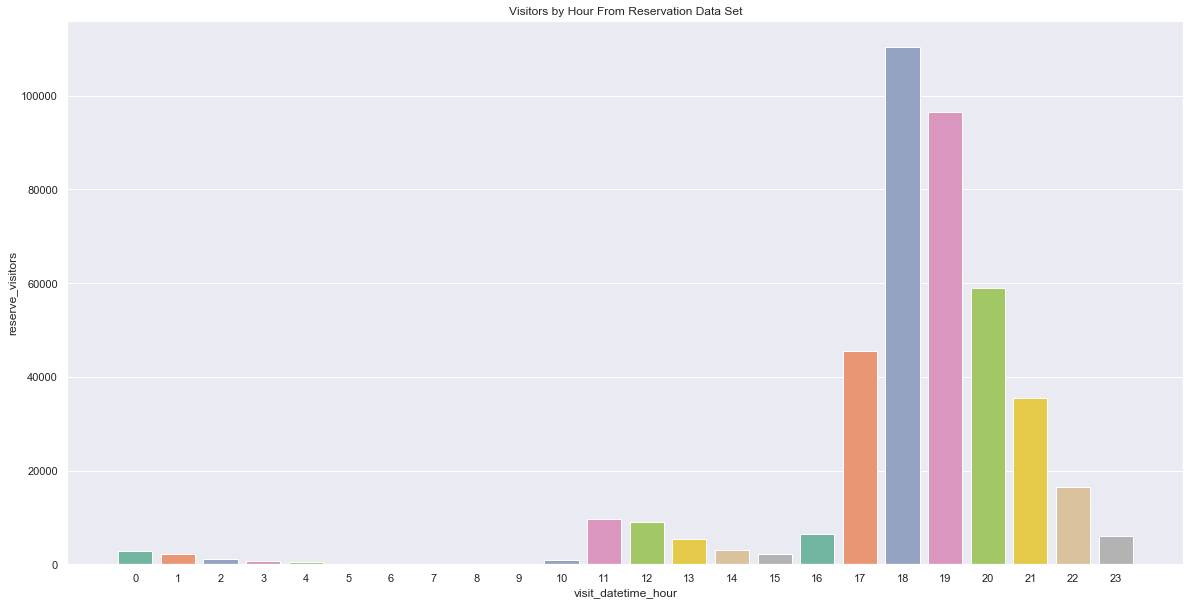

In [21]:
air_reserve["visit_datetime_hour"] = air_reserve["visit_datetime"].dt.hour
data = air_reserve.groupby(["visit_datetime_hour"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    x="visit_datetime_hour",
    y="reserve_visitors",
    data=data,
    palette="Set2"
)

plt.title("Visitors by Hour From Reservation Data Set")

plt.plot()

* Reservations are made typically for the dinner hours in the evening.

[]

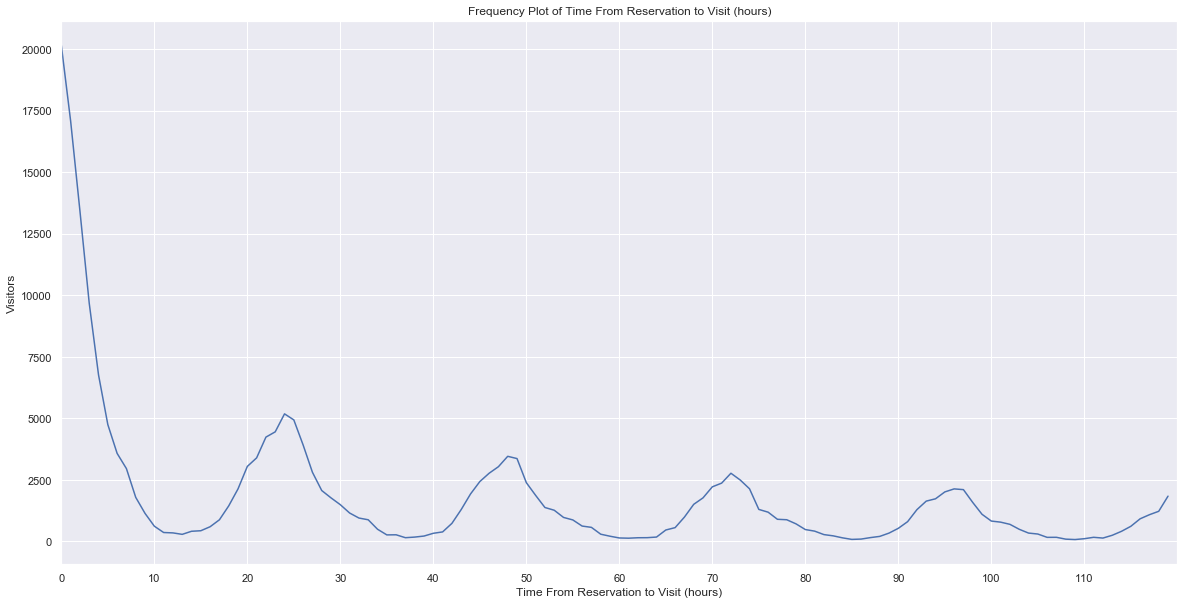

In [22]:
air_reserve["time_reserve_to_visit"] = air_reserve["visit_datetime"] - air_reserve["reserve_datetime"]
air_reserve["time_reserve_to_visit"] = (air_reserve["time_reserve_to_visit"]/timedelta(hours=1)).astype(int)

data_cutoff = 24*5

data = air_reserve.groupby(["time_reserve_to_visit"]).sum().reset_index()
data = data.loc[data["time_reserve_to_visit"] < data_cutoff]
x="time_reserve_to_visit"
y="reserve_visitors"

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(
    x=x,
    y=y,
    data=data,
    palette="Set2"
)

plt.title("Frequency Plot of Time From Reservation to Visit (hours)")
plt.xlabel("Time From Reservation to Visit (hours)")
plt.ylabel("Visitors")

plt.xlim(0,data_cutoff)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

plt.plot()

* The time, here shown in hours, between making a reservation and visiting the restaurant follow a nice 24-hour pattern.
* The most popular strategy is to reserve a couple of hours before the visit, but if the reservation is made more in advance then it seems to be common to book a table in the evening for one of the next evenings.
* This plot is truncated to show this pattern, which continues towards longer time scales.
* Very long time gaps between reservation and visit are not uncommon. Those are the most extreme values for the air data, up to more than a year in advance:

## EDA Hot Pepper Gormet (hpg_reserve)

In [23]:
hpg_reserve.head(3)

hpg_store_id      visit_datetime    reserve_datetime  \
0  hpg_c63f6f42e088e50f 2016-01-01 11:00:00 2016-01-01 09:00:00   
1  hpg_dac72789163a3f47 2016-01-01 13:00:00 2016-01-01 06:00:00   
2  hpg_c8e24dcf51ca1eb5 2016-01-01 16:00:00 2016-01-01 14:00:00   

   reserve_visitors visit_datetime_date visit_datetime_time  \
0                 1          2016-01-01            11:00:00   
1                 3          2016-01-01            13:00:00   
2                 2          2016-01-01            16:00:00   

  reserve_datetime_date reserve_datetime_time  
0            2016-01-01              09:00:00  
1            2016-01-01              06:00:00  
2            2016-01-01              14:00:00

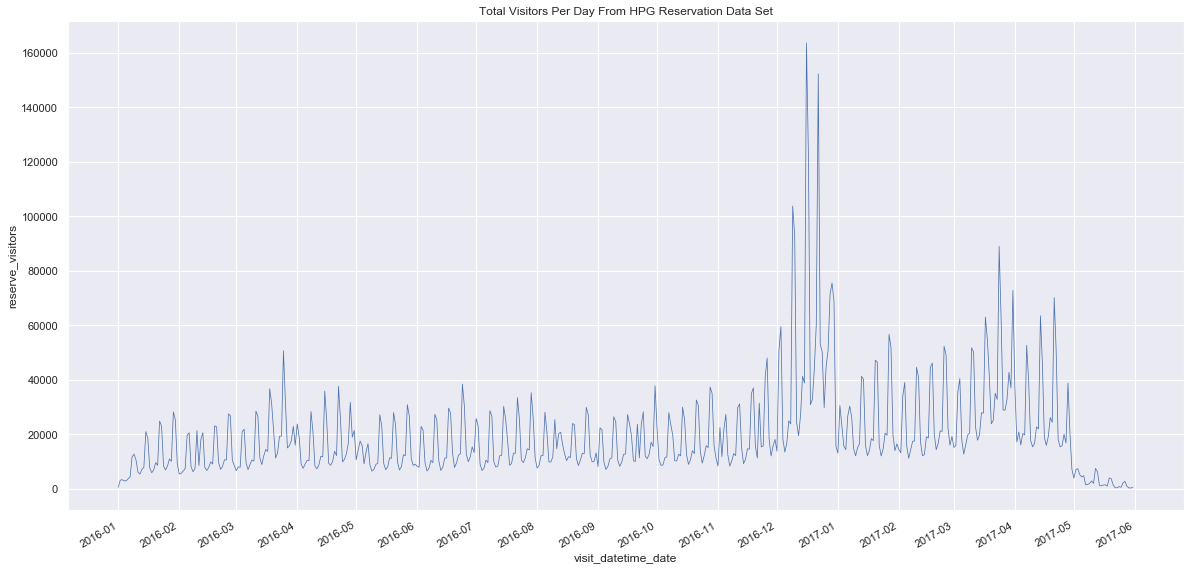

0        2016-01-13
1        2016-01-14
2        2016-01-15
3        2016-01-16
4        2016-01-18
5        2016-01-19
6        2016-01-20
7        2016-01-21
8        2016-01-22
9        2016-01-23
10       2016-01-25
11       2016-01-26
12       2016-01-27
13       2016-01-28
14       2016-01-29
15       2016-01-30
16       2016-02-03
17       2016-02-04
18       2016-02-05
19       2016-02-06
20       2016-02-08
21       2016-02-09
22       2016-02-10
23       2016-02-11
24       2016-02-12
25       2016-02-13
26       2016-02-15
27       2016-02-16
28       2016-02-17
29       2016-02-18
            ...    
252078   2017-03-17
252079   2017-03-18
252080   2017-03-21
252081   2017-03-22
252082   2017-03-23
252083   2017-03-24
252084   2017-03-25
252085   2017-03-27
252086   2017-03-28
252087   2017-03-29
252088   2017-03-30
252089   2017-03-31
252090   2017-04-01
252091   2017-04-03
252092   2017-04-04
252093   2017-04-05
252094   2017-04-06
252095   2017-04-07
252096   2017-04-08


air_store_id visit_date  visitors day_of_week  day_of_week_no  \
0  air_ba937bf13d40fb24 2016-01-13        25   Wednesday               2   
1  air_ba937bf13d40fb24 2016-01-14        32    Thursday               3   
2  air_ba937bf13d40fb24 2016-01-15        29      Friday               4   

     month  month_no  visit_log  visit_diff  visit_seasonal  \
0  January         1   3.218876         NaN             NaN   
1  January         1   3.465736         7.0             NaN   
2  January         1   3.367296        -3.0             NaN   

   visit_seasonal_diff  
0                  NaN  
1                  NaN  
2                  NaN

In [94]:
hpg_reserve.head(3)
data = hpg_reserve.groupby(["visit_datetime_date"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(
    x="visit_datetime_date",
    y="reserve_visitors",
    size=3.0,
    data=data,
    legend=False,
    palette="Set2"
)

fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Total Visitors Per Day From HPG Reservation Data Set')

plt.show()

print(air_visit_data.loc[:,"visit_date"])
air_visit_data.head(3)

[]

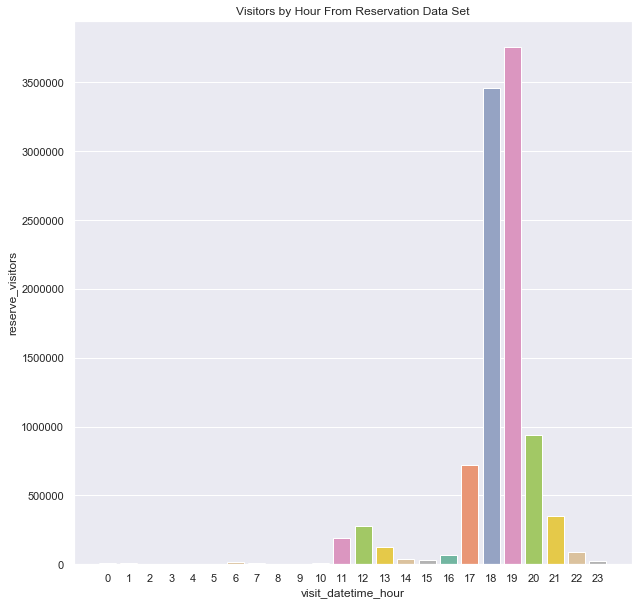

In [25]:
hpg_reserve["visit_datetime_hour"] = hpg_reserve["visit_datetime"].dt.hour
data = hpg_reserve.groupby(["visit_datetime_hour"]).sum().reset_index()

fig, ax = plt.subplots(figsize=(10,10))

sns.set(style="darkgrid")

sns.barplot(
    x="visit_datetime_hour",
    y="reserve_visitors",
    data=data,
    palette="Set2"
)

plt.title("Visitors by Hour From Reservation Data Set")

plt.plot()

[]

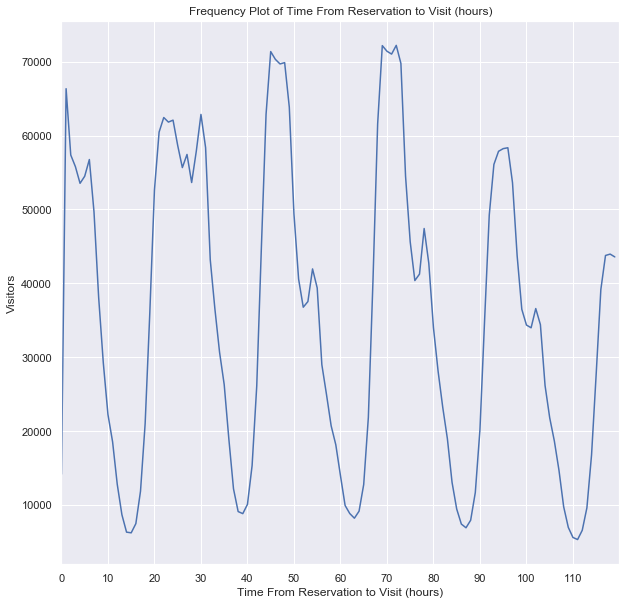

In [26]:
hpg_reserve["time_reserve_to_visit"] = hpg_reserve["visit_datetime"] - hpg_reserve["reserve_datetime"]
hpg_reserve["time_reserve_to_visit"] = (hpg_reserve["time_reserve_to_visit"]/timedelta(hours=1)).astype(int)

data_cutoff = 24*5

data = hpg_reserve.groupby(["time_reserve_to_visit"]).sum().reset_index()
data = data.loc[data["time_reserve_to_visit"] < data_cutoff]
x="time_reserve_to_visit"
y="reserve_visitors"

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10,10))

sns.lineplot(
    x=x,
    y=y,
    data=data,
    palette="Set2"
)

plt.title("Frequency Plot of Time From Reservation to Visit (hours)")
plt.xlabel("Time From Reservation to Visit (hours)")
plt.ylabel("Visitors")

plt.xlim(0,data_cutoff)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

plt.plot()

* Here the visits after reservation follow a more orderly pattern, with a clear spike in Dec 2016.As above for the air data, we also see reservation visits dropping off as we get closer to the end of the time frame.
* Again, most reservations are for dinner, and we see another nice 24-hour pattern for making these reservations.
* It’s worth noting that here the last few hours before the visit don’t see more volume than the 24 or 48 hours before. This is in stark constrast to the air data.

## EDA Air Store Info (air_store_info)

Visualise Spatial Information

In [27]:
air_store_info.head(3)

air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   

    latitude   longitude  
0  34.695124  135.197852  
1  34.695124  135.197852  
2  34.695124  135.197852

In [28]:
japan_coordinates = (
    air_store_info.loc[100,'latitude'],
    air_store_info.loc[100,'longitude']
)

m = folium.Map(
    location=japan_coordinates, 
    tiles='Stamen Toner',
    zoom_start=5,
    control_scale=True
)

marker_cluster = MarkerCluster().add_to(m)

folium.TileLayer('cartodbpositron').add_to(marker_cluster)
print(air_store_info.shape)

for i in np.arange(len(air_store_info)):
    folium.Marker(
        [air_store_info.latitude[i], air_store_info.longitude[i]],
        popup=air_store_info.air_store_id[i],
    ).add_to(marker_cluster)

m

(829, 5)


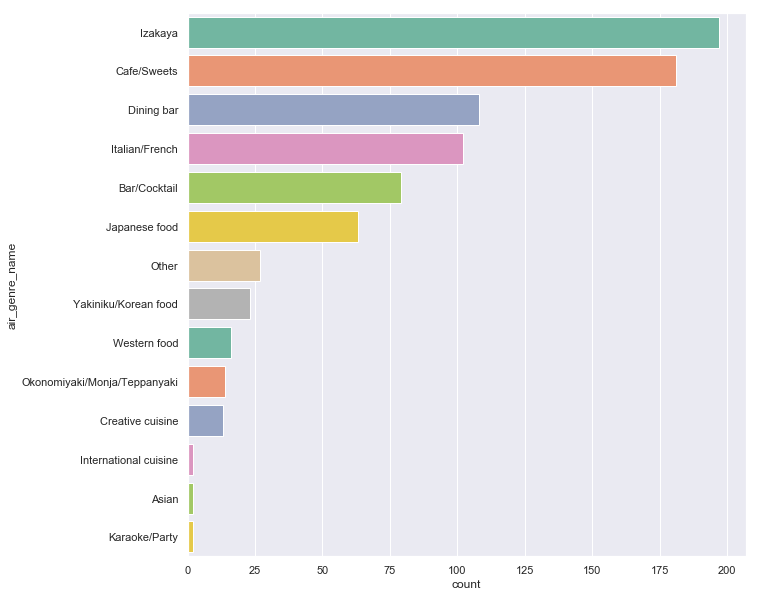

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.countplot(
    y="air_genre_name",
    data=air_store_info,
    order=air_store_info["air_genre_name"].value_counts().index,
    palette="Set2"
)

plt.show()

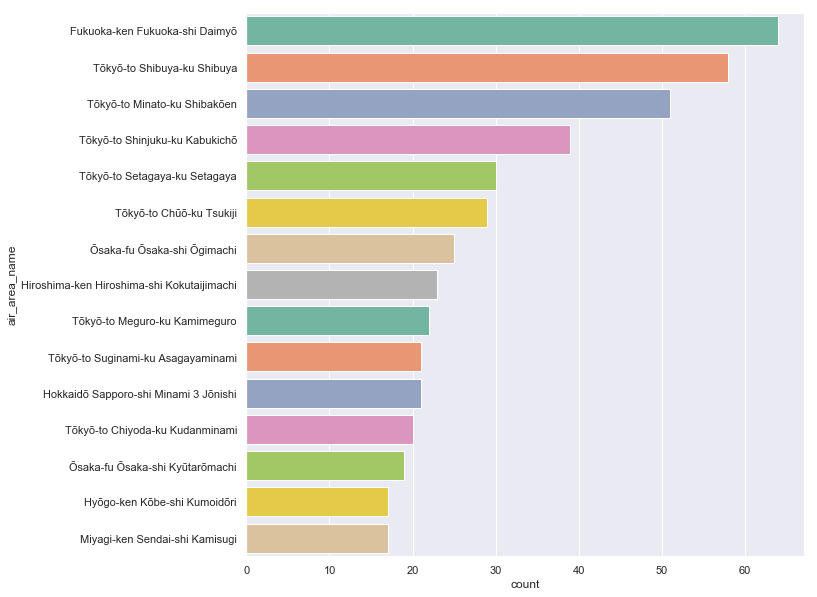

In [30]:
fig, ax = plt.subplots(figsize=(10,10))

# data = air_store_info.groupby("air_area_name").value_counts.

ax = sns.countplot(
    y="air_area_name",
    data=air_store_info,
    order=air_store_info["air_area_name"].value_counts().iloc[:15].index,
    palette="Set2"
)

plt.show()

* The most popular type of eating place is Izakaya, a type of informal pub, followed by Cafes.
* Fukuoka has the most air locations, followed by various districts of Tokyo.

## EDA HPG Store Info (hpg_store_info)

In [31]:
hpg_store_info.head(3)

hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221

In [32]:
japan_coordinates = (hpg_store_info.loc[100,'latitude'], hpg_store_info.loc[100,'longitude'])

m = folium.Map(
    location=japan_coordinates, 
    tiles='Stamen Toner',
    zoom_start=5,
    control_scale=True
)

marker_cluster = MarkerCluster().add_to(m)

folium.TileLayer('cartodbpositron').add_to(marker_cluster)
print(hpg_store_info.shape)

for i in np.arange(len(hpg_store_info)):
    folium.Marker(
        [hpg_store_info.latitude[i], hpg_store_info.longitude[i]],
        popup=hpg_store_info.hpg_store_id[i],
    ).add_to(marker_cluster)

m

(4690, 5)


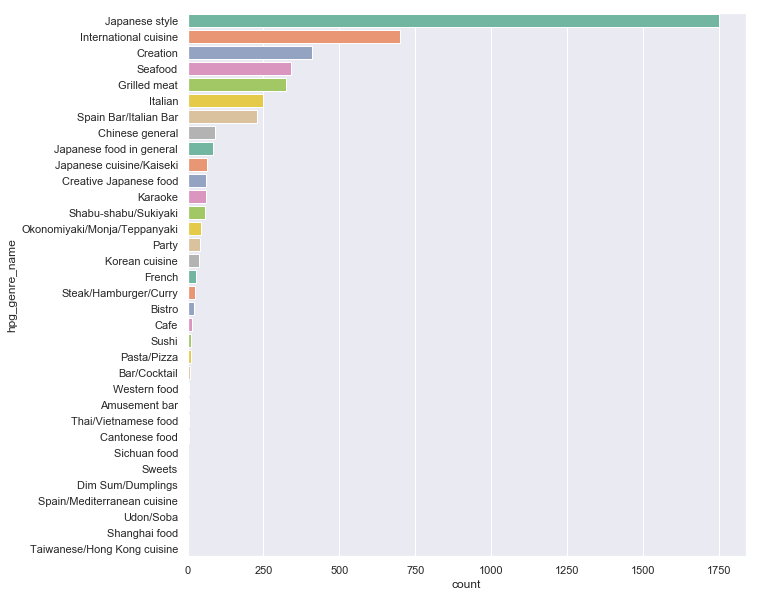

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.countplot(
    y="hpg_genre_name",
    data=hpg_store_info,
    order=hpg_store_info["hpg_genre_name"].value_counts().index,
    palette="Set2"
)

plt.show()

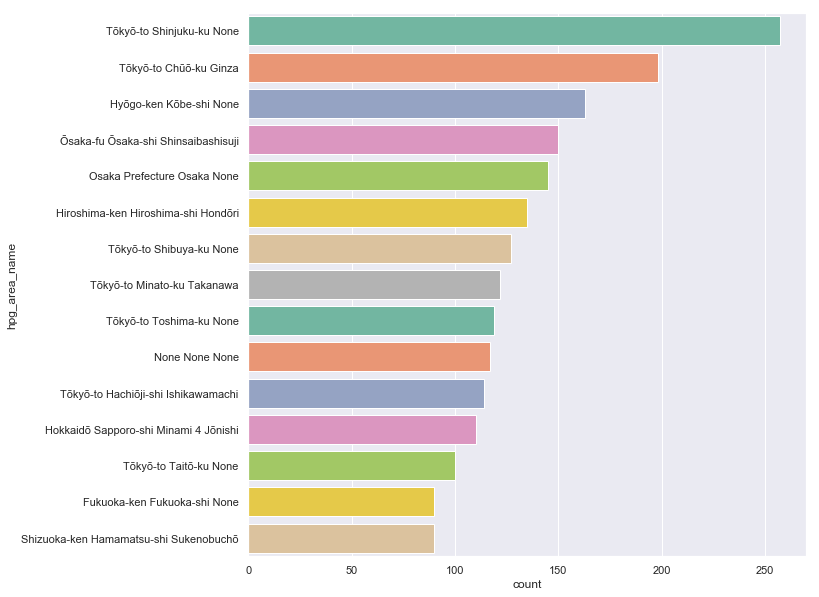

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.countplot(
    y="hpg_area_name",
    data=hpg_store_info,
    order=hpg_store_info["hpg_area_name"].value_counts().iloc[:15].index,
    palette="Set2"
)

plt.show()

* The HPG description contains a larger variety of genres than in the air data. Here, “Japanese style” appears to contain many more places that are categorised more specifically in the air data. The same applies to “International cuisine”.
* In the top 15 area we find again Tokyo and Osaka to be prominently present.

## EDA Holidays (hpg_store_info)

In [35]:
date_info.head()

calendar_date day_of_week  holiday_flg calendar_date_date calendar_date_time
0    2016-01-01      Friday            1         2016-01-01           00:00:00
1    2016-01-02    Saturday            1         2016-01-02           00:00:00
2    2016-01-03      Sunday            1         2016-01-03           00:00:00
3    2016-01-04      Monday            0         2016-01-04           00:00:00
4    2016-01-05     Tuesday            0         2016-01-05           00:00:00

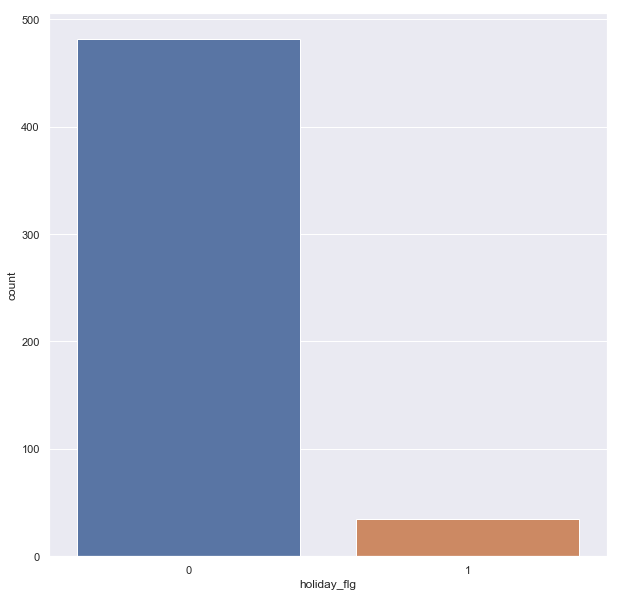

In [36]:
fig, ax = plt.subplots(figsize=(10,10))

sns.countplot(
    x="holiday_flg",
    data=date_info
)

plt.show()

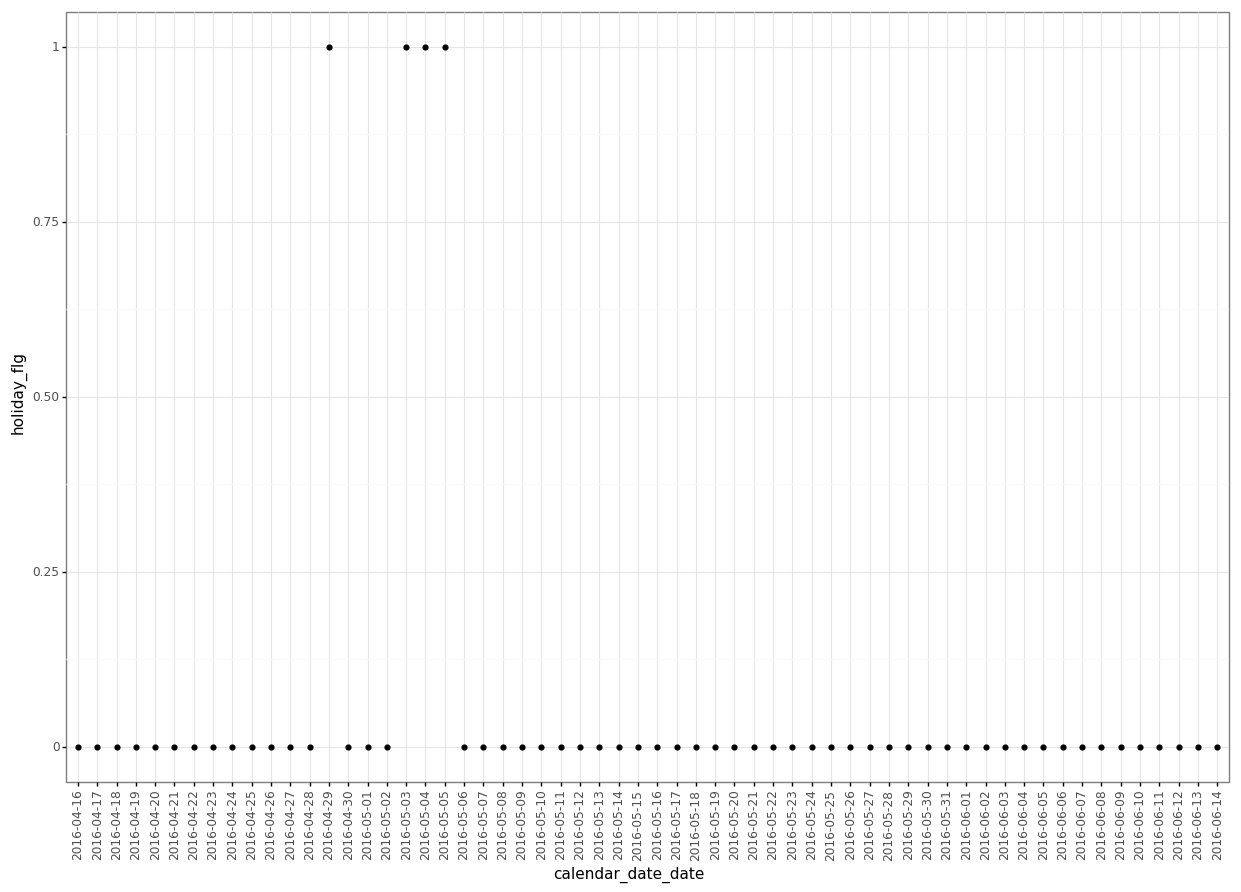

<ggplot: (126974034731)>

In [37]:
data = date_info.loc[
    np.logical_and(
        date_info.calendar_date > "2016-04-15",
        date_info.calendar_date < "2016-06-15"
    )
]

(ggplot(data=data,
           mapping=aes(x='calendar_date_date', y="holiday_flg"))
    + geom_point()
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90), figure_size=(15,10))
#     + p9.figure_size(10,10)
)


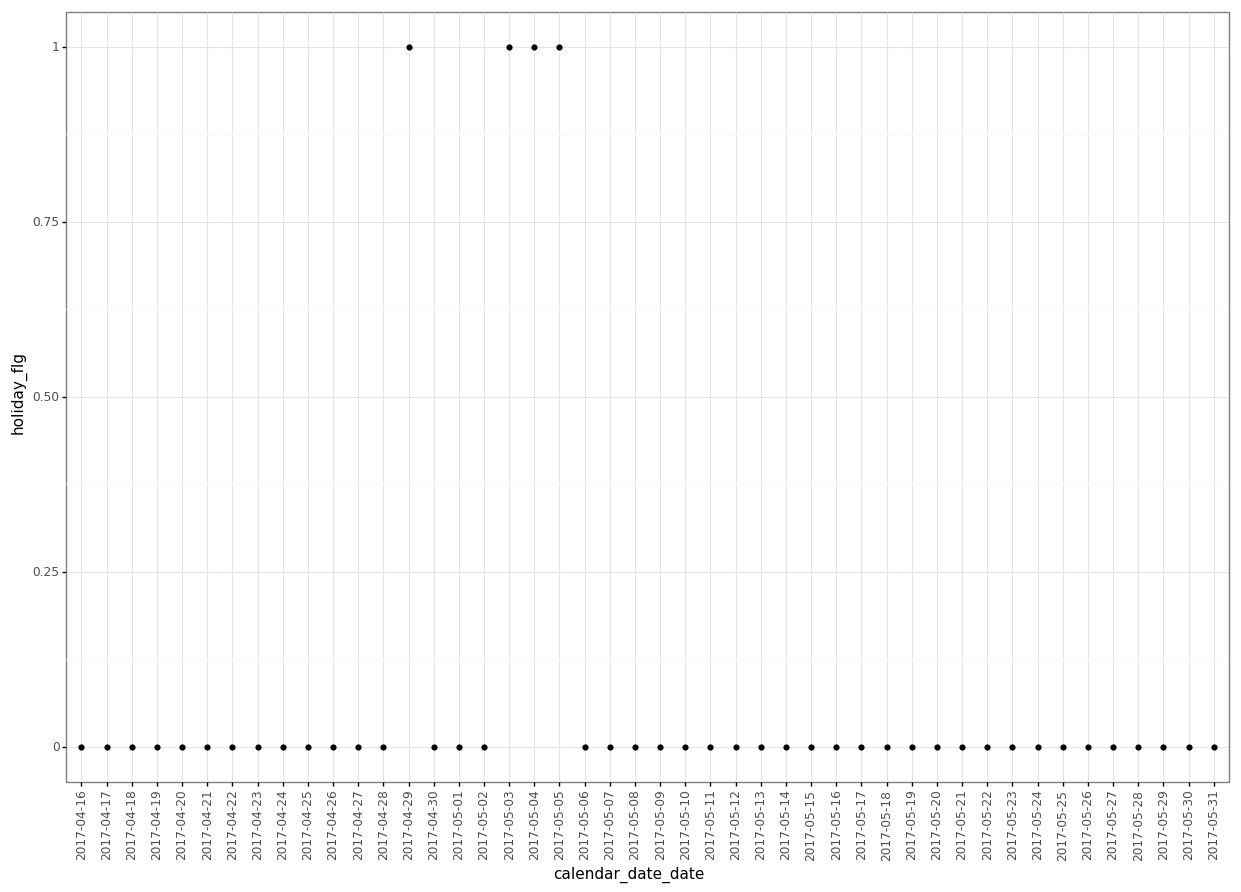

<ggplot: (-9223371909879854136)>

In [38]:
data = date_info.loc[
    np.logical_and(
        date_info.calendar_date > "2017-04-15",
        date_info.calendar_date < "2017-06-15"
    )
]

(ggplot(data=data,
           mapping=aes(x='calendar_date_date', y="holiday_flg"))
    + geom_point()
    + theme_bw()
    + theme(axis_text_x = element_text(angle=90), figure_size=(15,10))
#     + p9.figure_size(10,10)
)

* The same days were holidays in late Apr / May in 2016 as in 2017.
* There are about 7% holidays in our data:

## Feature Relationships

In [39]:
air_visit_data.head(3)
air_visit_data.dtypes

air_store_id              object
visit_date        datetime64[ns]
visitors                   int64
day_of_week               object
day_of_week_no             int64
month                     object
month_no                   int64
dtype: object

In [40]:
air_store_info.head(3)
air_store_info.dtypes

air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object

In [41]:
air_visit_store_join = air_visit_data.merge(
    air_store_info,
    on='air_store_id',
    how='left'
)

air_visit_store_join.head(3)

air_store_id visit_date  visitors day_of_week  day_of_week_no  \
0  air_ba937bf13d40fb24 2016-01-13        25   Wednesday               2   
1  air_ba937bf13d40fb24 2016-01-14        32    Thursday               3   
2  air_ba937bf13d40fb24 2016-01-15        29      Friday               4   

     month  month_no air_genre_name                 air_area_name   latitude  \
0  January         1     Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068   
1  January         1     Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068   
2  January         1     Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068   

    longitude  
0  139.751599  
1  139.751599  
2  139.751599

In [42]:
data = air_visit_store_join.groupby(["visit_date", "air_genre_name"])["visitors"].mean().reset_index()
print(data.head())
# data = air_data
# print(data.head())

plot = (
    ggplot(data=data, mapping=aes("visit_date", "visitors", color = "air_genre_name"))
    + geom_line()
    + labs(y = "Average number of visitors to 'air' restaurants", x = "Date")
    + theme(legend_position = "none")
    + scale_y_log10()
    + facet_wrap("air_genre_name", scales='fixed')
    + theme(axis_text_x = element_text(angle=90), figure_size=(15,10))
)

  visit_date    air_genre_name   visitors
0 2016-01-01      Bar/Cocktail  15.111111
1 2016-01-01       Cafe/Sweets  26.600000
2 2016-01-01  Creative cuisine   7.000000
3 2016-01-01        Dining bar  15.142857
4 2016-01-01    Italian/French   5.750000


* The values tend to stay between 10 and 100 each day except for Karaoke/Party which has more variation, which might be expected due to the nature of the venue.

In [43]:
# air_visit = air_visit_data.merge(
#     air_reserve,
#     on='air_store_id',
#     how='left'
# )

# print(air_data.head())



# # list = []
# # for i in range(len(air_visit)):
# #     if np.logical_and(air_visit.visit_datetime, air_visit.reserve_datetime) is np.NaN or np.NaT:
# #         list.append(False)
# #     else:
# #         list.append(True)

In [44]:
# air_data.visit_datetime.isna().sum()
# len(air_data.visit_datetime)

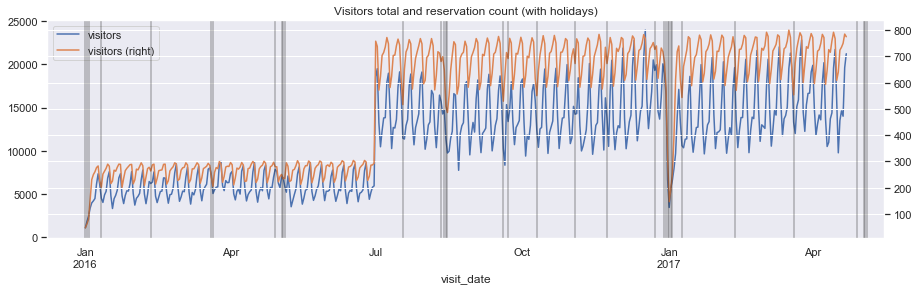

In [45]:
#Plot the cumulative visits
air_visit_data.groupby('visit_date',squeeze=True,sort=True)['visitors'].sum().plot(legend=True);

air_visit_data.groupby('visit_date',squeeze=True,sort=True)['visitors'].count().plot(
    legend=True,
    figsize=(15,4),
    secondary_y=True,
    title='Visitors total and reservation count (with holidays)'
)

for x in date_info.query('holiday_flg==1')["calendar_date"]:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

Instead of the sum of visits, a better measurement is the mean of the cumulative visits (sum of all visits divided by number of reservations or, which is the same, the number of "active" restaurants). The series does not show the gap in July 2016 anymore, though variance seems to become smaller for some months.

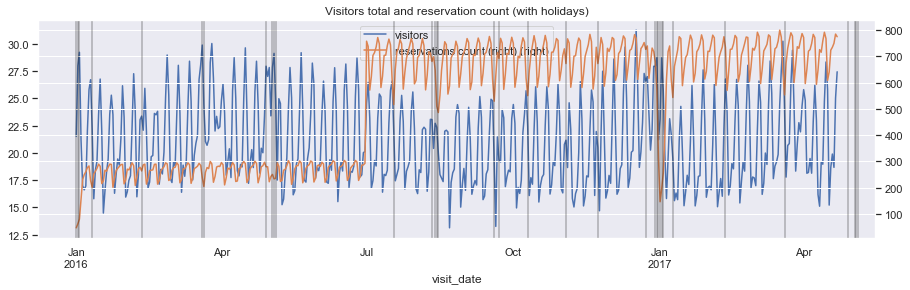

In [46]:
air_data_visit_mean_df = pd.DataFrame()
air_data_visit_mean_df["visit_mean"] = air_visit_data.groupby('visit_date',squeeze=True,sort=True)['visitors'].mean()
air_data_visit_mean_df["reserve_count"] = air_visit_data.groupby('visit_date',squeeze=True,sort=True)['visitors'].count()

air_data_visit_mean_df["visit_mean"].plot(
    figsize=(15,4),
    legend=True,
    title='Visitors mean (with holidays)',
    label='visitors'
)

air_data_visit_mean_df["reserve_count"].plot(
    legend=True,
    figsize=(15,4),
    secondary_y=True,
    title='Visitors total and reservation count (with holidays)',
    label="reservations count (right)"
)

for x in date_info.query('holiday_flg==1')["calendar_date"]:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

In [47]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

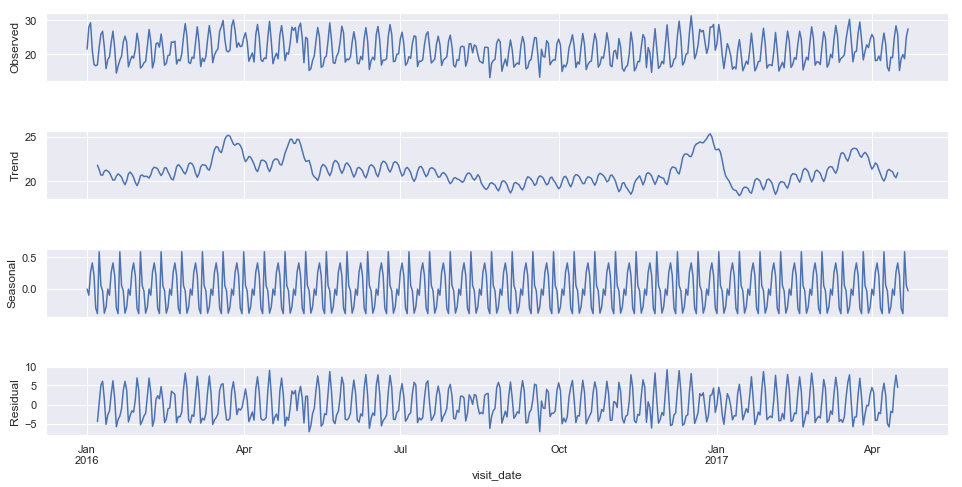

In [48]:
decomposition = seasonal_decompose(air_data_visit_mean_df["visit_mean"], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

## Pre-ARIMA analysis: make the series stationary

The first step in applying ARIMA methodology is to check for stationarity. "Stationarity" implies that the series remains at a fairly constant level over time. If a trend exists, as in most economic or business applications, then your data is NOT stationary. The data should also show a constant variance in its fluctuations over time. This is easily seen with a series that is heavily seasonal and growing at a faster rate. In such a case, the ups and downs in the seasonality will become more dramatic over time. Without these stationarity conditions being met, many of the calculations associated with the process cannot be computed. 

Changes in mean happen when the series has a overall trend, e.g. it increases/decreasing. In that case use differentiation: create a new series y with the first difference y=xt

-xt-1 (this is the "I" in ARIMA models), and take seasonal differences (which you can account for in ARIMA model).
Changes is variance mean that oscillations change. To fix this a log of the series compresses oscillations.
Changes in autocorrelation means that oscillations become broader (or narrower). If you have this I think you are screwed..

The Dickey-Fuller test helps us deciding whether a series is stationary. The test's null hypothesis is that the series is non-stationary. If the Test Statistic output of the Dickey-Fuller test is less than the Critical Value, we can reject the null hypothesis and say that the series is stationary.
Below we notice that the original time series (using the mean of visits) is fairly stationary: Test Statistic=-3.796104 > Critical Value (1%) = -3.444615. Applying 1st or seasonal differentiation greatly improves the test results (Test Statistic = -6.608968 and 7.196314, respectively). A weekly periodic structure is clearly visible in the data, so I lean towards using seasonal differentiation. Takign the log of the data helps but does not seem to be a main factor in improving stationarity. This means that variance is fairly stable.

In [49]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

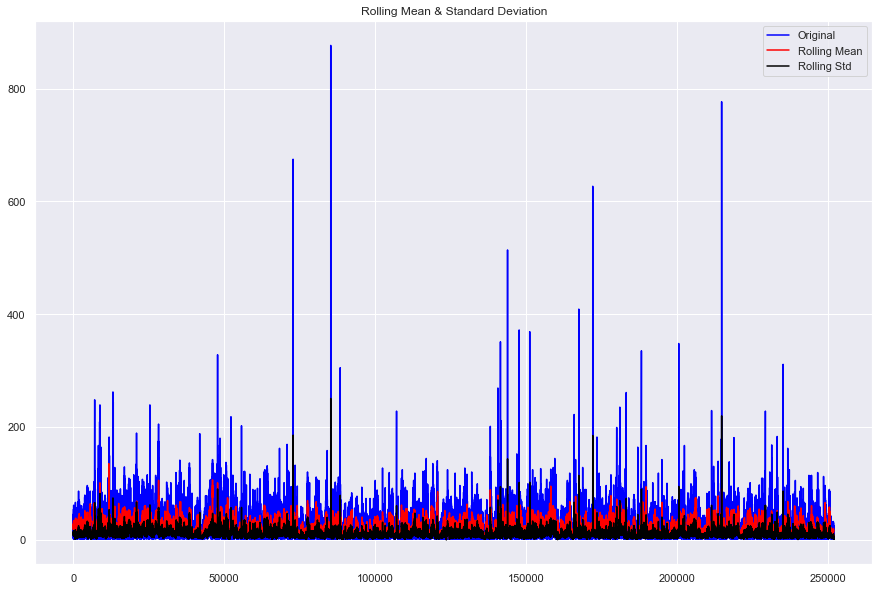

Results of Dickey-Fuller Test:
Test Statistic                    -22.652038
p-value                             0.000000
#Lags Used                         80.000000
Number of Observations Used    252027.000000
Critical Value (1%)                -3.430376
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64


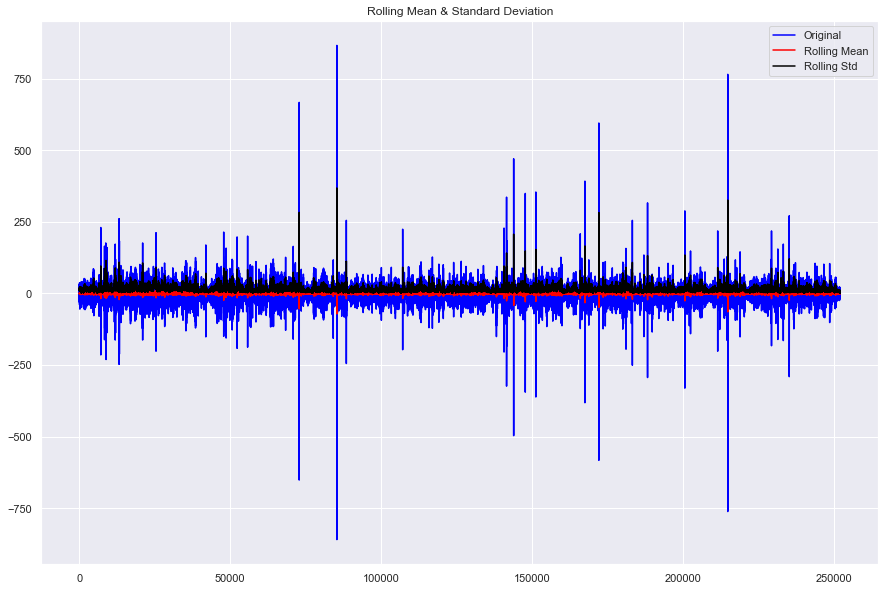

Results of Dickey-Fuller Test:
Test Statistic                    -71.542574
p-value                             0.000000
#Lags Used                         82.000000
Number of Observations Used    252024.000000
Critical Value (1%)                -3.430376
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64


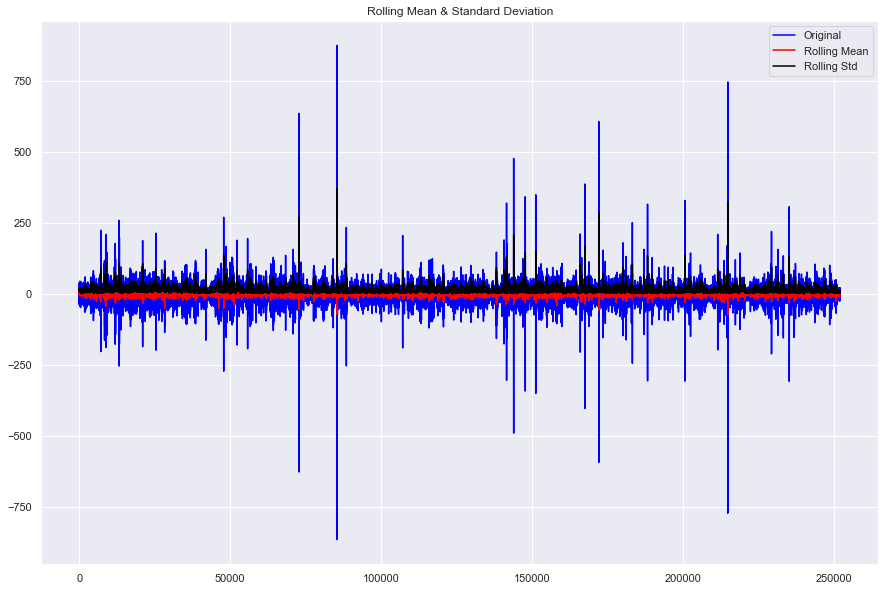

Results of Dickey-Fuller Test:
Test Statistic                    -66.476033
p-value                             0.000000
#Lags Used                         85.000000
Number of Observations Used    252015.000000
Critical Value (1%)                -3.430376
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64


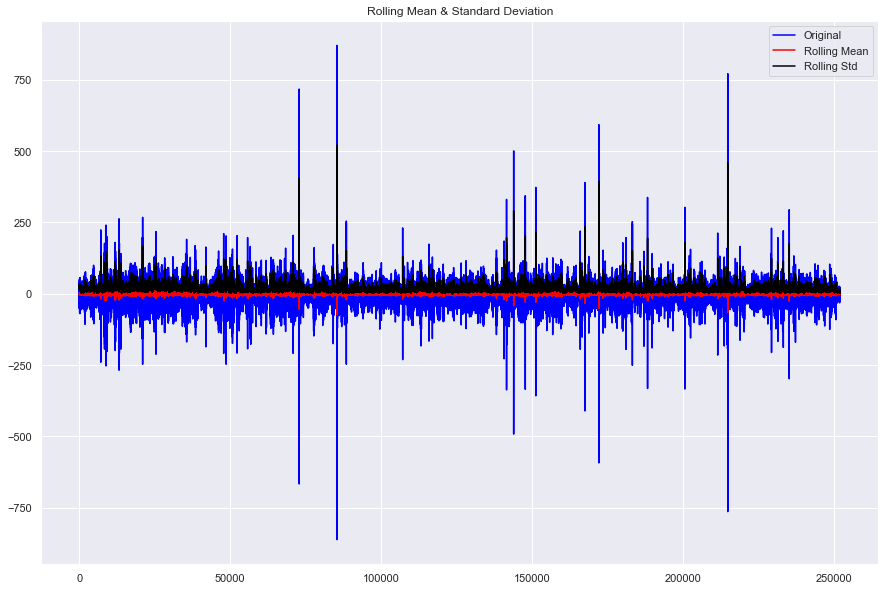

Results of Dickey-Fuller Test:
Test Statistic                   -104.134235
p-value                             0.000000
#Lags Used                         86.000000
Number of Observations Used    252013.000000
Critical Value (1%)                -3.430376
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64


In [50]:
test_stationarity(air_visit_data.visitors); #-3.796104
# Log is a minor improvement, meaning that the variance is stable
air_visit_data["visit_log"] = air_visit_data.visitors.apply(lambda x: np.log(x))  
'''test_stationarity(air_visit_data.visit_log) #-3.830754'''
# Although I see no real global trend, 1st difference strongly improves stationarity
air_visit_data['visit_diff'] = air_visit_data.visitors - air_visit_data.visitors.shift(1)  
test_stationarity(air_visit_data.visit_diff.dropna(inplace=False)) #-6.608968e+00
# Seasonal difference: take a weekly season improves stationarity even more
air_visit_data['visit_seasonal'] = air_visit_data.visitors - air_visit_data.visitors.shift(7)
test_stationarity(air_visit_data.visit_seasonal.dropna(inplace=False)) #-7.196314e+00
# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
air_visit_data['visit_seasonal_diff'] = air_visit_data.visit_diff - air_visit_data.visit_diff.shift(7)
test_stationarity(air_visit_data.visit_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

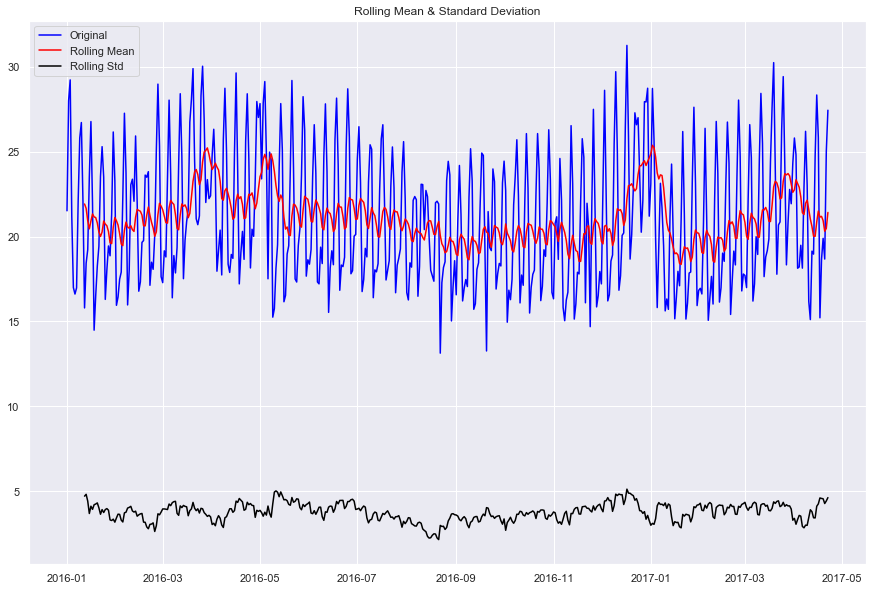

Results of Dickey-Fuller Test:
Test Statistic                  -3.796104
p-value                          0.002947
#Lags Used                      16.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


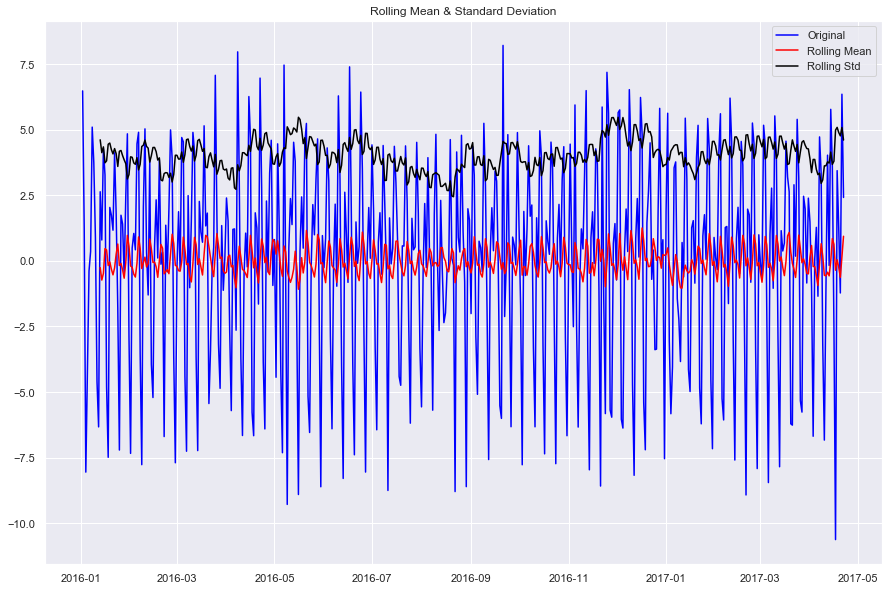

Results of Dickey-Fuller Test:
Test Statistic                -6.608968e+00
p-value                        6.448883e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (1%)           -3.444709e+00
Critical Value (5%)           -2.867871e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


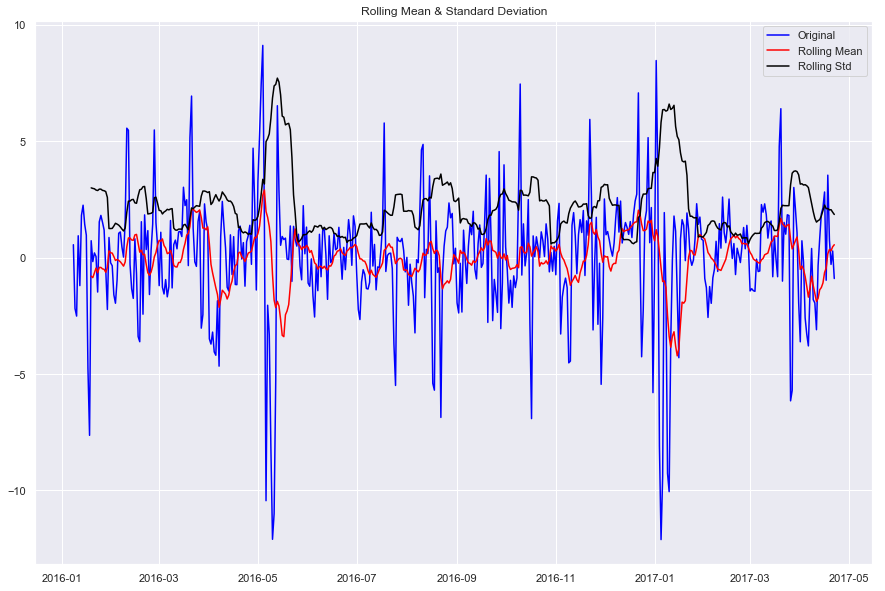

Results of Dickey-Fuller Test:
Test Statistic                -7.196314e+00
p-value                        2.429479e-10
#Lags Used                     1.500000e+01
Number of Observations Used    4.550000e+02
Critical Value (1%)           -3.444804e+00
Critical Value (5%)           -2.867913e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


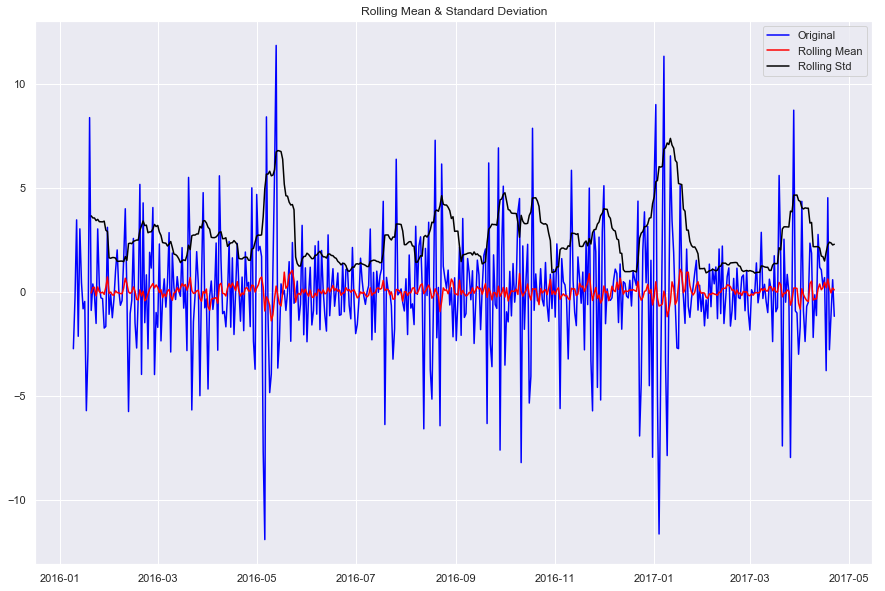

Results of Dickey-Fuller Test:
Test Statistic                -9.427797e+00
p-value                        5.288819e-16
#Lags Used                     1.600000e+01
Number of Observations Used    4.530000e+02
Critical Value (1%)           -3.444868e+00
Critical Value (5%)           -2.867941e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [51]:
test_stationarity(air_data_visit_mean_df["visit_mean"]); #-3.796104
# Log is a minor improvement, meaning that the variance is stable
air_data_visit_mean_df["visit_log"] = air_data_visit_mean_df["visit_mean"].apply(lambda x: np.log(x))  
'''test_stationarity(air_data_visit_mean_df.visit_log) #-3.830754'''
# Although I see no real global trend, 1st difference strongly improves stationarity
air_data_visit_mean_df['visit_diff'] = air_data_visit_mean_df["visit_mean"] - air_data_visit_mean_df["visit_mean"].shift(1)  
test_stationarity(air_data_visit_mean_df.visit_diff.dropna(inplace=False)) #-6.608968e+00
# Seasonal difference: take a weekly season improves stationarity even more
air_data_visit_mean_df['visit_seasonal'] = air_data_visit_mean_df["visit_mean"] - air_data_visit_mean_df["visit_mean"].shift(7)
test_stationarity(air_data_visit_mean_df.visit_seasonal.dropna(inplace=False)) #-7.196314e+00
# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
air_data_visit_mean_df['visit_mean_seasonal_diff'] = air_data_visit_mean_df.visit_diff - air_data_visit_mean_df.visit_diff.shift(7)
test_stationarity(air_data_visit_mean_df.visit_mean_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

ACF and PACF of the visit mean:


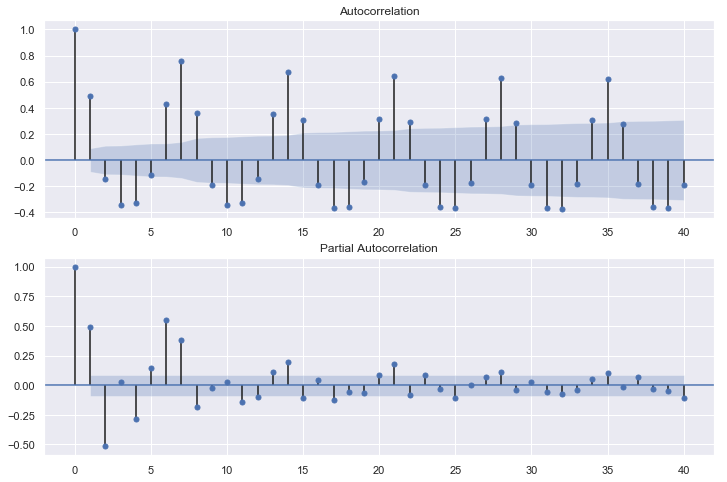

In [52]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(
    air_data_visit_mean_df["visit_mean"],
    lags=40,
    alpha=.05,
    ax=ax1
)

ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(
    air_data_visit_mean_df["visit_mean"],
    lags=40,
    alpha=.05,
    ax=ax2
)

print("ACF and PACF of the visit mean:")

The AC plot first crosses the critical boundary(the dotted line) at 2, **therefore the first parameter for the p is 2**.

The same is true for the PAC plot, therefore the q value is 2.

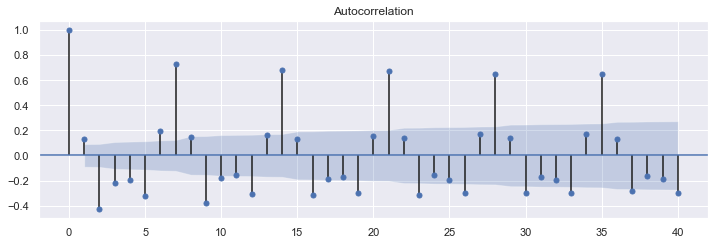

In [53]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air_data_visit_mean_df["visit_diff"][1:], lags=40, alpha=.05, ax=ax1)

ACF and PACF of the 7-day differenced visit mean:


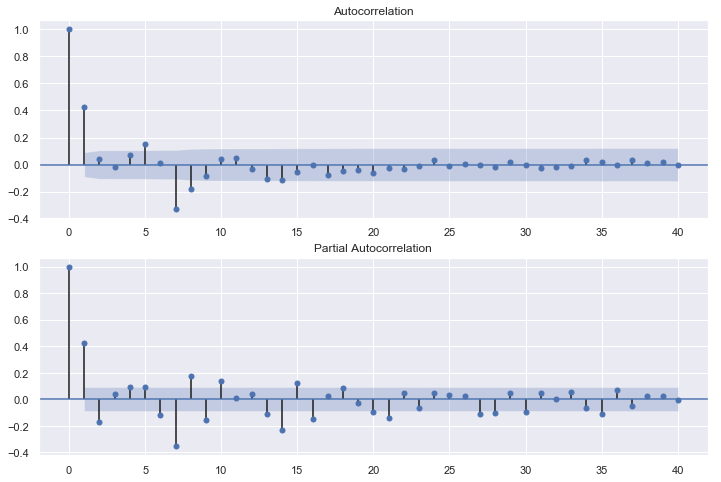

In [54]:
print("ACF and PACF of the 7-day differenced visit mean:")
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(
    air_data_visit_mean_df["visit_seasonal"][8:],
    lags=40,
    alpha=.05,
    ax=ax1
)

ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(air_data_visit_mean_df["visit_seasonal"][8:], lags=40, alpha=.05, ax=ax2)

ACF tails off quickly therefore data is stationarry

In [114]:
import plotly
import cufflinks as cf
from pyramid.arima import auto_arima

plotly.tools.set_credentials_file(username='wil_hol', api_key='KrP2PiQSdU6Fb43v7Ske')

data = air_data_visit_mean_df["visit_log"]

stepwise_model = auto_arima(
    data,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=7,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=-520.646, BIC=-512.341, Fit time=0.132 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=-627.831, BIC=-611.220, Fit time=0.352 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=-843.366, BIC=-826.755, Fit time=0.744 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=-819.876, BIC=-799.112, Fit time=1.157 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=-597.348, BIC=-584.889, Fit time=0.177 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=-845.528, BIC=-824.765, Fit time=1.267 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=-771.031, BIC=-754.420, Fit time=1.470 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 2, 7); AIC=-

In [115]:
#         date_info.calendar_date > "2017-04-15",
#         date_info.calendar_date < "2017-06-15"
train = data.loc[:"2017-03-22"]
test = data.loc["2017-03-22":"2017-04-22"]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 2, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [116]:
print(test)

visit_date
2017-03-22    3.029472
2017-03-23    3.038119
2017-03-24    3.268088
2017-03-25    3.381941
2017-03-26    3.182143
2017-03-27    2.908857
2017-03-28    3.034901
2017-03-29    3.125859
2017-03-30    3.088168
2017-03-31    3.191638
2017-04-01    3.250787
2017-04-02    3.211736
2017-04-03    2.898046
2017-04-04    2.902048
2017-04-05    2.969884
2017-04-06    2.898287
2017-04-07    3.129758
2017-04-08    3.265898
2017-04-09    3.136300
2017-04-10    2.784305
2017-04-11    2.715562
2017-04-12    2.951919
2017-04-13    2.942841
2017-04-14    3.208659
2017-04-15    3.344468
2017-04-16    3.251878
2017-04-17    2.722426
2017-04-18    2.926221
2017-04-19    2.990747
2017-04-20    2.927359
2017-04-21    3.220100
2017-04-22    3.312305
Name: visit_log, dtype: float64


In [117]:
future_forecast = stepwise_model.predict(n_periods=32)
print(future_forecast)

[3.03987759 3.20656128 3.34482622 3.26386086 2.95003455 2.94385288
 3.03602282 3.01667011 3.22029958 3.35853951 3.2510079  2.9278286
 2.96306535 3.03154193 3.01558081 3.22046632 3.35874484 3.26748064
 2.95004358 2.95997809 3.04296542 3.0249538  3.2290946  3.36737283
 3.26618512 2.94526024 2.97068926 3.04482721 3.02809268 3.23271214
 3.37101385 3.27591723]


In [118]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

pd.concat([test,future_forecast],axis=1).iplot()

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~wil_hol/0 or inside your plot.ly account where it is named 'Plotly Playground 2018-11-02 16:47:21'


## Try Out SARIMA as a Benchmark

In [56]:
# https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
model = SARIMAX(
    endog=air_data_visit_mean_df["visit_log"],
    exog=None,
    order=(1, 1, 0),
    seasonal_order=(1, 1, 0, 7)
)

C:\Users\WilliamHoltam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [58]:
results = model.fit()
print(results.summary())
# results

                                 Statespace Model Results                                
Dep. Variable:                         visit_log   No. Observations:                  478
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                 317.916
Date:                           Fri, 02 Nov 2018   AIC                           -629.831
Time:                                   15:39:40   BIC                           -617.373
Sample:                               01-01-2016   HQIC                          -624.930
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1728      0.034     -5.147      0.000      -0.239      -0.107
ar.S.L7       -0.4182      0.029    -14.196

In [59]:
model.predict()

TypeError: predict() missing 1 required positional argument: 'params'